In [1]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
sc.settings.n_jobs = 40
sc.set_figure_params(figsize=(4,4), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 100

# SEACells

## Run PCA

In [ ]:
adata = sc.read_h5ad("Data/Output_231215_adata_scvi_random_sampleID.h5ad")

In [ ]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="cell_ranger", batch_key="sampleID"
) # 2m

In [ ]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True) # 10m

In [ ]:
adata.write_h5ad("Data/Output_231215_adata_scvi_random_sampleID_SEACells.h5ad")

## Start SEACells

In [2]:
import SEACells

In [3]:
adata = sc.read_h5ad("Data/Output_231215_adata_scvi_random_sampleID_SEACells.h5ad")

In [4]:
## Core parameters 
n_SEACells = 5240 # 393060/75 = 5240.9333333
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data
## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [5]:
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5,
                  use_sparse=True)

Welcome to SEACells!


In [6]:
model.construct_kernel_matrix()
M = model.kernel_matrix # 285m

Computing kNN graph using scanpy NN ...


/home/ssun1116/anaconda3/envs/seacells/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Computing radius for adaptive bandwidth kernel...


  0%|          | 0/393060 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/393060 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/393060 [00:00<?, ?it/s]

Constructing CSR matrix...


In [7]:
# Initialize archetypes
model.initialize_archetypes() # 43m

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 4939 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 311/311 [11:46<00:00,  2.27s/it]

Selecting 301 cells from greedy initialization.


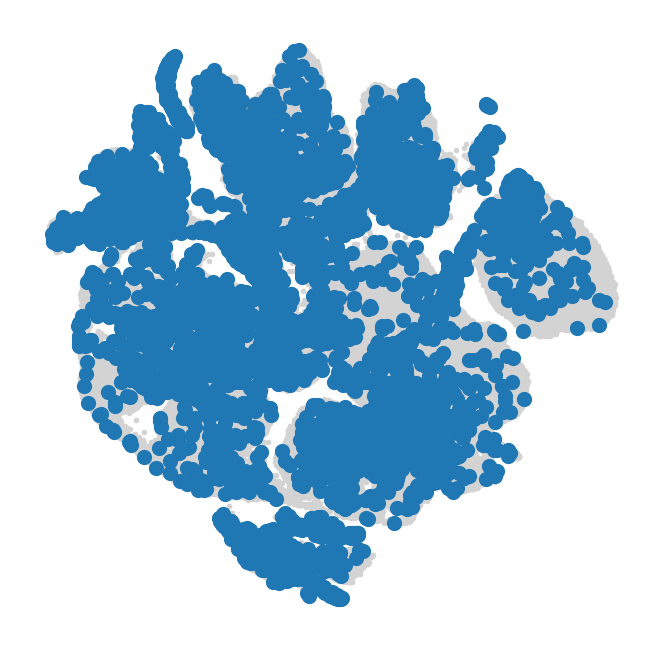

In [8]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata, model)

In [9]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.01145
Starting iteration 1.


: 

In [ ]:
# Check for convergence 
model.plot_convergence()

In [14]:
model.write_h5ad("SEACells_model.h5ad")

AttributeError: 'SEACells' object has no attribute 'write_h5ad'

## Summarizing data

In [ ]:
SEACell_ad = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='counts')
SEACell_ad

In [ ]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=True)

# Test for pySCENIC

In [4]:
import pyscenic

In [9]:
import loompy as lp
f_loom_path_scenic = "Data/Output_230911_adata_scvi_random_sampleID_annot.loom"
f_pyscenic_output = "Data/Output_pySCENIC.loom"
f_final_loom = 'Data/Output_pySCENIC_final.loom'

In [11]:
adata.X = adata.layers["counts"]

In [13]:
adata.X

<393060x49133 sparse matrix of type '<class 'numpy.float32'>'
	with 1226312506 stored elements in Compressed Sparse Row format>

In [14]:
# path to loom file with basic filtering applied
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs) # 10 minutes.

- To use the pySCENIC pipeline, we need two auxilliary datasets avaiable at cistargetDBs website:
1. Databases ranking the whole human genome based on regulatory features (i.e. TFs) in *feather* format.
2. Motif to TF annotations database providing the missing link between an enriched motif and the TF that binds that motif. (TSV text file where every line represents a particular annotation.)
3. A list of transcription factors required for the network inference step (GENIE3/GRNBoost2).

In [17]:
# Ranking databases
!wget https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
!wget https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
# Motif databases
!wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

--2023-10-24 15:42:27--  https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311298530 (297M)
Saving to: ‘hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather’

hg38_10kbp_up_10kbp 100%[===================>] 296.88M  9.12MB/s    in 14m 59s 

2023-10-24 15:57:28 (338 KB/s) - ‘hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather’ saved [311298530/311298530]

--2023-10-24 15:57:29--  https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
Resolving resources.aertslab.org (resourc

In [18]:
f_db_glob = "/data2/scData/Brain_Allen_v2/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )
f_db_names

'/data2/scData/Brain_Allen_v2/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather /data2/scData/Brain_Allen_v2/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

In [7]:
# Transcription factors list
!wget https://resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt
f_tfs = "/data2/scData/Brain_Allen_v2/allTFs_hg38.txt"

--2023-10-24 15:03:10--  https://resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11690 (11K) [text/plain]
Saving to: ‘allTFs_hg38.txt’

allTFs_hg38.txt     100%[===================>]  11.42K  --.-KB/s    in 0s      

2023-10-24 15:03:12 (74.4 MB/s) - ‘allTFs_hg38.txt’ saved [11690/11690]



### STEP 1: Gene regulatory network inference, and generation of co-expression modules

In [31]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 40


2023-10-24 23:53:12,310 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-10-24 23:57:10,494 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/home/ssun1116/anaconda3/envs/BrainAtlas/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40871 instead
  warnings.warn(
preparing dask client
parsing input
creating dask graph
^C
not shutting down client, client was created externally
finished
2023-10-25 13:08:02,705 - distributed.scheduler - WARNING - Communication with worker tcp://127.0.0.1:35531 failed during replication: CommClosedError: in <TCP (closed) ConnectionPool.gather local=tcp://127.0.0.1:44514 remote=tcp://127.0.0.1:35531>: Stream is closed
2023-10-25 13:08:02,726 - distributed.scheduler - WARNING - Communication with worker tcp://127.0.0.1:40413 failed during replication: CommClosedError: in <TCP (closed) ConnectionPool.gather l

Read in adjacencies matrix:

In [ ]:
adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')
adjacencies.head()

### STEP 2-3: Regulon prediction aka cisTarget from CLI

In [ ]:
import glob
# ranking databases
f_db_glob = "/data2/scData/Brain_Allen_v2/gene_based/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )
# motif databases
f_motif_path = "/data2/scData/Brain_Allen_v2/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [ ]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 40

### STEP 4: Cellular enrichment (aka AUCell) from CLI

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [ ]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 40

### Integrate the output

In [ ]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###